# King County House Price Prediction Model

## Import Necessary Functions and Packages


In [1]:
from training.helpers.data_reader import csv_loader
from training.helpers.aws_services import S3Buckets
from training.data_engineering.transformation import Transformation
from training.model.model import ModelInputs
from experiment.visualize import corr_plot, corr_table, num_feature_plot, target_plot, cat_feature_plot, acf_plot, norm_plot
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats import diagnostic as diag
from math import sqrt
import matplotlib.pyplot as plt
import shap
import yaml
import warnings
warnings.filterwarnings('ignore')

with open('training/config.yaml', 'r') as file:
    train_yaml = yaml.safe_load(file)

## Import King County Housing Dataset

In [2]:
s3 = S3Buckets.credentials('us-east-2')

# Upload Raw Dataset to Raw-Data Bucket if Not Already Uploaded
#uncleaned_kc_data = csv_loader('https://raw.githubusercontent.com/Amberlynnyandow/dsc-1-final-project-online-ds-ft-021119/master/kc_house_data.csv')
# s3.upload_dataframe_to_s3(df = uncleaned_kc_data, bucket_name= 'jibbs-raw-datasets', object_name='uncleaned_kc_housing_data.csv')

# Import Uncleaned Dataset From Raw-Data Bucket and Load as Dataframe
uncleaned_file = s3.read_file('jibbs-raw-datasets', 'uncleaned_kc_housing_data.csv')
data = csv_loader(uncleaned_file)

## Perform Data Preprocessing and Feature Engineering

In [3]:
# Transformation and Feature Engineering
transform = Transformation(data)
data = transform.run_pipeline()

## Create Training and Test Data from Features and Target

In [4]:
model_input = ModelInputs(data)
train_features, test_features, train_target, test_target = model_input.run_pipeline()

## Model Estimation

### Baseline Model (Linear Regression)

MSE : 8.78e+09
MAE : 6.82e+04
RMSE : 9.37e+04
R2-Score : 0.786


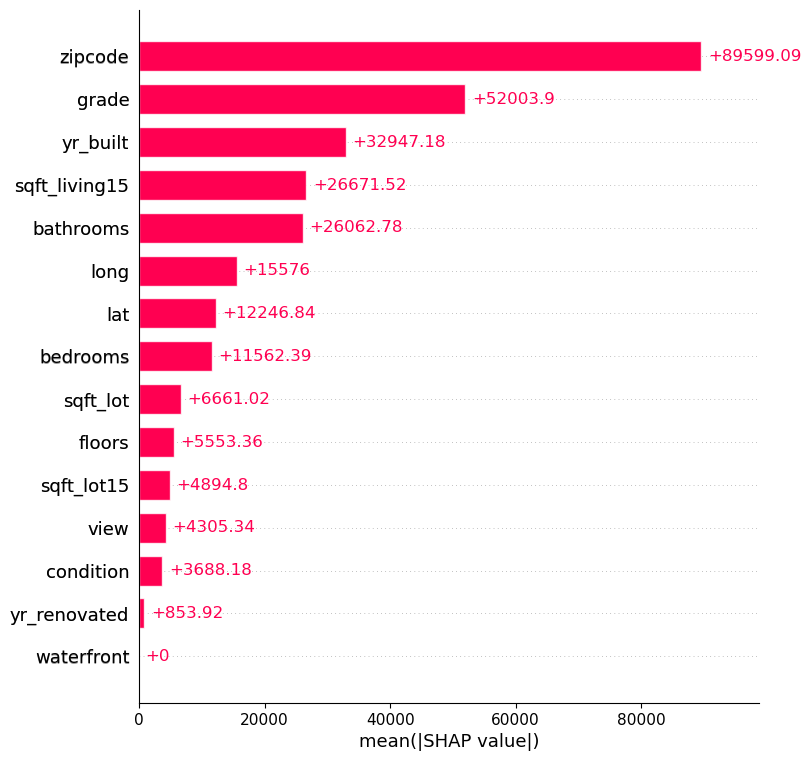

In [5]:
# Instantiate Linear Regression Model
regression_model = LinearRegression()

# Fit the model
regression_model.fit(train_features, train_target)

# Get the Price Prediction on the Test Data
test_prediction = regression_model.predict(test_features)

# Model Performance Metrics
# Calculate the mean squared error
model_mse = mean_squared_error(test_target, test_prediction)

# Calculate the mean absolute error
model_mae = mean_absolute_error(test_target, test_prediction)

# Calculate the root mean squared error
model_rmse = sqrt(mean_squared_error(test_target, test_prediction))

# Calculate the r-squared value
model_r2 = r2_score(test_target, test_prediction)

# Display the output
print(f"MSE : {model_mse:.3}")
print(f"MAE : {model_mae:.3}")
print(f"RMSE : {model_rmse:.3}")
print(f"R2-Score : {model_r2:.3}")

# Explain the model's predictions using SHAP
explainer = shap.explainers.Linear(regression_model, test_features)
shap_values = explainer(test_features)

# visualize the Model's explanation
shap.plots.bar(shap_values, max_display=99)

#### Base Model Results and Hypothesis Testing

In [6]:
# Create the input
X_model = sm.add_constant(train_features)

# Create an OLS model
model = sm.OLS(train_target, X_model)

# Fit the model
est = model.fit(cov_type = 'HC0')

# SHow Model Summary 
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     3259.
Date:                Wed, 24 Jul 2024   Prob (F-statistic):               0.00
Time:                        04:15:26   Log-Likelihood:            -1.8386e+05
No. Observations:               14287   AIC:                         3.677e+05
Df Residuals:                   14271   BIC:                         3.679e+05
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.236e+07   9.61e+05    -23.274

#### Base Model Diagnostics

##### Autocorrelation Check
The autocorrelation function is used to check for the presence of autocorrelation. The ACF plot clearly shows that the model does not suffer from autocorrelation in its residuals as every lag beyond the first lag is very close to zero.

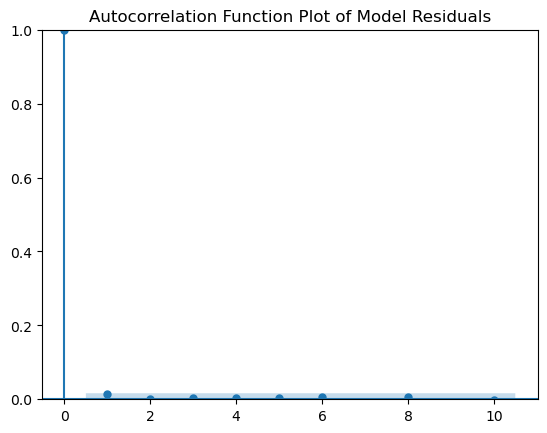

In [7]:
# Plot Model Residual Autocorrelation Function
acf_plot(est)

##### Heteroskedasticity check
The Lagrange multiplier statistic for the Breusch-Pagan Test is 1905.144 and the corresponding p-value is 0. Because this p-value is way less than 0.05, we reject the null hypothesis. Consequently, there is heteroscedasticity is present in the regression model. However, this can be dealt with by employing heteroskedastic variance -ccovariance matrix when refitting the model.

In [8]:
# Perform Bresuch-Pagan test
labels = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f (p-value)']
test = diag.het_breuschpagan(est.resid, X_model, robust = True)

lzip(labels, test)

[('Lagrange multiplier statistic', 1187.0102189862698),
 ('p-value', 1.0090357962556358e-243),
 ('f-value', 86.2078170458043),
 ('f (p-value)', 9.181526126347134e-255)]

##### Normality Check
The model QQ-Plot follows the diagonal line in the plot and mean of residuals are very close to zero, indicating that the model errors are normally distributed.

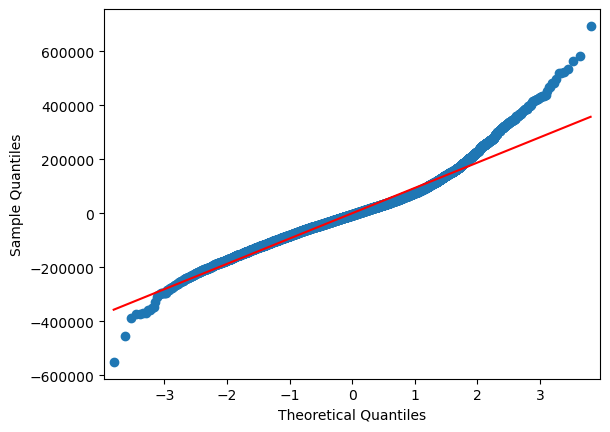

Mean of Residuals: -8.05914684152449e-06


In [9]:
# Check for the Normality
norm_plot(est)

# Check that the mean of the residual = 0
mean_residuals = sum(est.resid) / len(est.resid)
print(f"Mean of Residuals: {mean_residuals}")

### Random Forest Model

MSE : 6.37e+09
MAE : 5.52e+04
RMSE : 7.98e+04
R2-Score : 0.845


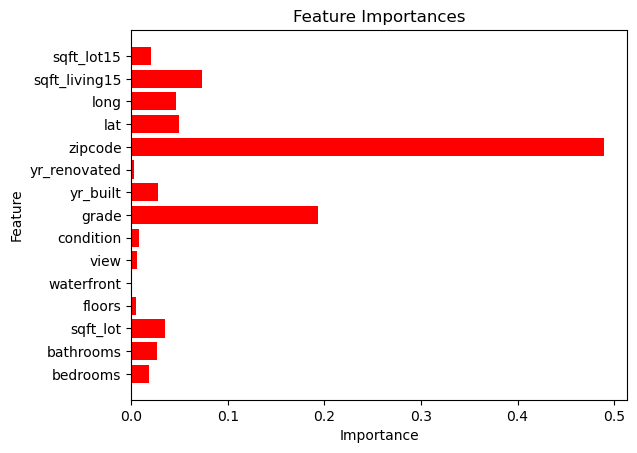

In [10]:
# Instantiate Random Forest Regressor Model
regression_model = RandomForestRegressor(random_state=420)

# Fit the model
regression_model.fit(train_features, train_target)

# Get the Price Prediction on the Test Data
test_prediction = regression_model.predict(test_features)

# Model Performance Metrics
# Calculate the mean squared error
model_mse = mean_squared_error(test_target, test_prediction)

# Calculate the mean absolute error
model_mae = mean_absolute_error(test_target, test_prediction)

# Calculate the root mean squared error
model_rmse = sqrt(mean_squared_error(test_target, test_prediction))

# Calculate the r-squared value
model_r2 = r2_score(test_target, test_prediction)

# Display the Output
print(f"MSE : {model_mse:.3}")
print(f"MAE : {model_mae:.3}")
print(f"RMSE : {model_rmse:.3}")
print(f"R2-Score : {model_r2:.3}")

# Model Feature Importances
importances = regression_model.feature_importances_
feature_names = train_features.columns
feature_importances = dict(zip(feature_names, importances))

# Visualization of the Most Important Determinants of Survival
plt.barh(feature_names, importances, color = 'red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### XGBoost Model

MSE : 6.25e+09
MAE : 5.49e+04
RMSE : 7.9e+04
R2-Score : 0.848


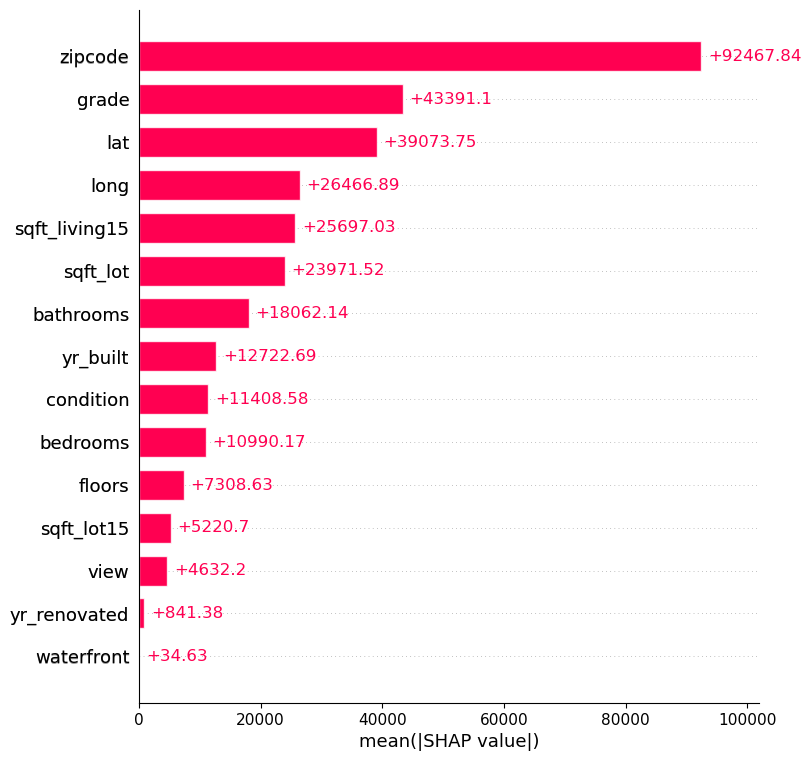

In [11]:
# Instantiate XGBRegressor Model
regression_model = XGBRegressor(random_state=420)

# Fit the model
regression_model.fit(train_features, train_target)

# Get the Price Prediction on the Test Data
test_prediction = regression_model.predict(test_features)

# Model Performance Metrics
# Calculate the mean squared error
model_mse = mean_squared_error(test_target, test_prediction)

# Calculate the mean absolute error
model_mae = mean_absolute_error(test_target, test_prediction)

# Calculate the root mean squared error
model_rmse = sqrt(mean_squared_error(test_target, test_prediction))

# Calculate the r-squared value
model_r2 = r2_score(test_target, test_prediction)

# Display the output
print(f"MSE : {model_mse:.3}")
print(f"MAE : {model_mae:.3}")
print(f"RMSE : {model_rmse:.3}")
print(f"R2-Score : {model_r2:.3}")

# Explain the model's predictions using SHAP
explainer = shap.Explainer(regression_model)
shap_values = explainer(train_features)

# visualize the Model's explanation
shap.plots.bar(shap_values, max_display=99)

### HistGradient Model

MSE : 5.95e+09
MAE : 5.39e+04
RMSE : 7.71e+04
R2-Score : 0.855


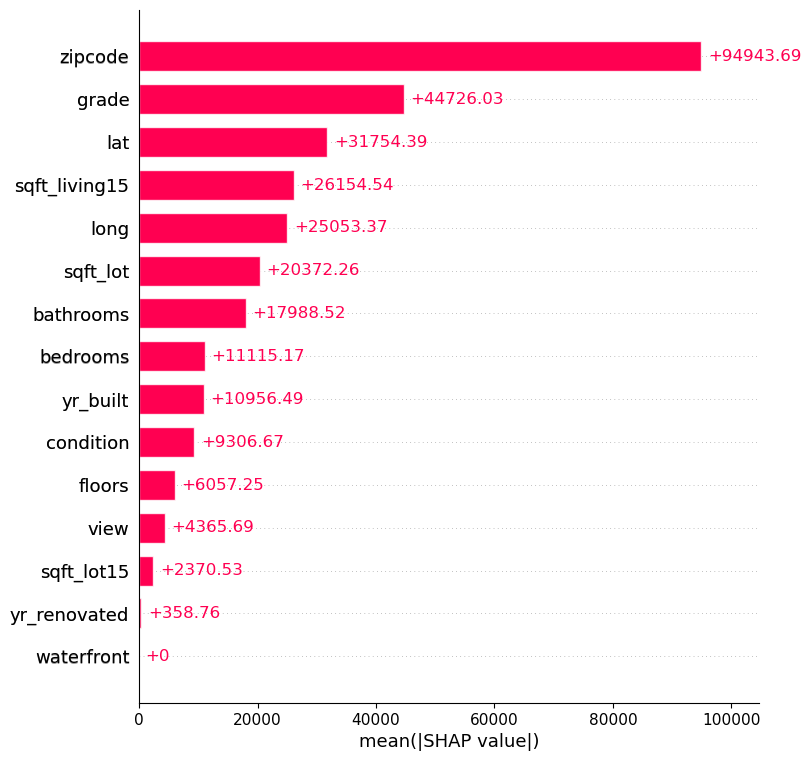

In [12]:
# Instantiate HistGradient Regressor Model
regression_model = HistGradientBoostingRegressor(random_state=420)

# Fit the model
regression_model.fit(train_features, train_target)

# Get the Price Prediction on the Test Data
test_prediction = regression_model.predict(test_features)

# Model Performance Metrics
# Calculate the mean squared error
model_mse = mean_squared_error(test_target, test_prediction)

# Calculate the mean absolute error
model_mae = mean_absolute_error(test_target, test_prediction)

# Calculate the root mean squared error
model_rmse = sqrt(mean_squared_error(test_target, test_prediction))

# Calculate the r-squared value
model_r2 = r2_score(test_target, test_prediction)

# Display the output
print(f"MSE : {model_mse:.3}")
print(f"MAE : {model_mae:.3}")
print(f"RMSE : {model_rmse:.3}")
print(f"R2-Score : {model_r2:.3}")

# Explain the model's predictions using SHAP
explainer = shap.Explainer(regression_model)
shap_values = explainer(train_features)

# visualize the Model's explanation
shap.plots.bar(shap_values, max_display=99)